## Exercise 2: Bias-variance trade-off and resampling techniques 

#### Overview of nature of the problem: 



In [1]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import common
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [7]:
np.random.seed(4155)
maxdegree = 12
n = 400
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
z = common.FrankeFunction(x, y) + 0.2*np.random.normal(0, size = n)
print(z.shape)

(400, 400)


In [3]:
#TODO: Number of bootstraps? 
n_bootstraps = 100
MSE_test = np.zeros(maxdegree)
MSE_train = np.zeros(maxdegree)
polydegree = np.arange(0,maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
#for each degree of poly:


In [4]:
for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
    model = common.LinearRegression()
    #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
    X = common.create_X(x, y, n=degree)  
    X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2)

    #reshape for broadcasting in MSE_test and MSE_val  
    y_test_ = np.reshape(y_test, newshape=(y_test.shape[0],1))
    #reshape for broadcasting in MSE_test and MSE_val  
    y_train_ = np.reshape(y_train, newshape=(y_train.shape[0],1))

    #y_train = np.reshape(y_train, newshape=(y_train.shape[0],1))
    #TODO: why scale?!?

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_pred = np.empty((y_test.shape[0], n_bootstraps))
    y_fit = np.empty((y_train.shape[0], n_bootstraps))
    
    for i in range(n_bootstraps):
        #bootstrap:
        x_, y_ = resample(X_train_scaled, y_train)
        #fit model to x_,y_ sample:
        #print(f"y_.shape : {y_.shape}")
        #clf =  model.fit(x_, y_)
        model.fit(x_, y_, SVDfit=False)
        #fit model and predict on test data:
        y_pred[:, i] = model.predict(X_test_scaled)
        #predict on train data:
        y_fit[:,i] = model.predict(X_train_scaled)
        

    #polydegree[degree] = degree
   
    MSE_test[degree] = np.mean( np.mean((y_test_ - y_pred)**2, axis=1, keepdims=True) )
    MSE_train[degree] = np.mean( np.mean((y_train_ - y_fit)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True))
    
plt.plot(polydegree, MSE_test,"m", label='MSE_test')
plt.plot(polydegree, MSE_train,"c", label='MSE_train')

plt.plot(polydegree, bias,"g--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error")

plt.grid(True)
plt.legend()
plt.show()

Looping through polynomials up to 12 degrees with 100 bootstraps:   0%|          | 0/12 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [160000, 400]

# Studying bias-variance tradeoff as dependance on the number of datpoints
The following section will create datasets with an increasing number of datapoints. The purpouse of this analysis is to study how the bias-variance tradeoff for Ordinary Least squares varies as a function of the number of datapoints. This is an addendum to the previous analysis where we studied the bias-variance tradeoff as a function of the model complexity. 

Looping through polynomials up to 12 degrees with 100 bootstraps: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


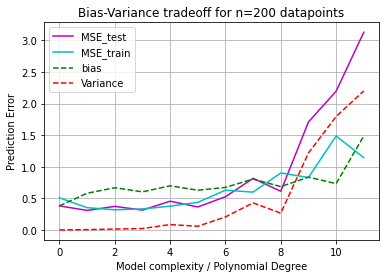

Looping through polynomials up to 12 degrees with 100 bootstraps: 100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


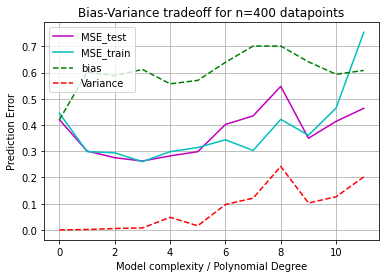

Looping through polynomials up to 12 degrees with 100 bootstraps: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


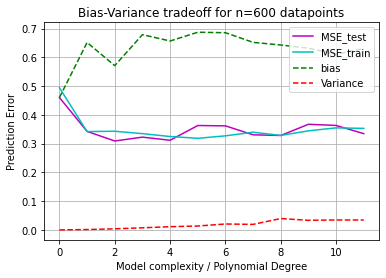

Looping through polynomials up to 12 degrees with 100 bootstraps: 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


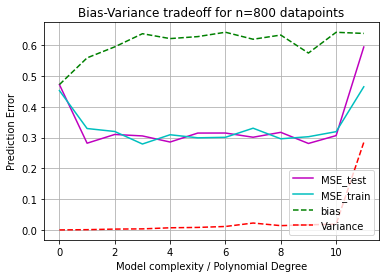

Looping through polynomials up to 12 degrees with 100 bootstraps: 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


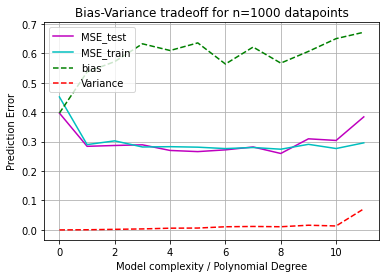

In [ ]:

n_list = [200, 400, 600, 800, 1000]
n_bootstraps = 100
maxdegree = 12
polydegree = np.arange(maxdegree)

for n in n_list:
    x = np.sort(np.random.uniform(0,1,n))
    y = np.sort(np.random.uniform(0,1,n))
    z = common.FrankeFunction(x, y) + 0.2*np.random.normal(0, size = n)

    MSE_test_n = np.zeros(maxdegree)
    MSE_train_n = np.zeros(maxdegree)
    variance_n = np.zeros(maxdegree)
    bias_n = np.zeros(maxdegree)

    for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
        model = common.LinearRegression()
        #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
        X = common.create_X(x, y, n=degree)    
        X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2)

        #reshape for broadcasting in MSE_test and MSE_val  
        y_test_ = np.reshape(y_test, newshape=(y_test.shape[0],1))
        #reshape for broadcasting in MSE_test and MSE_val  
        y_train_ = np.reshape(y_train, newshape=(y_train.shape[0],1))

        #y_train = np.reshape(y_train, newshape=(y_train.shape[0],1))
        #TODO: why scale?!?

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        y_pred = np.empty((y_test.shape[0], n_bootstraps))
        y_fit = np.empty((y_train.shape[0], n_bootstraps))
    
        for i in range(n_bootstraps):
            #bootstrap:
            x_, y_ = resample(X_train_scaled, y_train)
            #fit model to x_,y_ sample:
            #print(f"y_.shape : {y_.shape}")
            model.fit(x_, y_, SVDfit=False)
            #fit model and predict on test data:
            y_pred[:, i] = model.predict(X_test_scaled)
            #predict on train data:
            y_fit[:,i] = model.predict(X_train_scaled)
        

        #polydegree[degree] = degree
   
        MSE_test_n[degree] = np.mean( np.mean((y_test_ - y_pred)**2, axis=1, keepdims=True) )
        MSE_train_n[degree] = np.mean( np.mean((y_train_ - y_fit)**2, axis=1, keepdims=True) )
        bias_n[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance_n[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True))
    
    plt.plot(polydegree, MSE_test_n,"m", label='MSE_test')
    plt.plot(polydegree, MSE_train_n,"c", label='MSE_train')

    plt.plot(polydegree, bias_n,"g--", label='bias')
    plt.plot(polydegree, variance_n,"r--", label='Variance')

    plt.title(f"Bias-Variance tradeoff for n={n} datapoints")
    plt.xlabel("Model complexity / Polynomial Degree")
    plt.ylabel("Prediction Error")

    plt.grid(True)
    plt.legend()
    plt.show()

    
